In [151]:
!pip install deepface

In [152]:
from deepface import DeepFace
print(DeepFace.__version__)

0.0.95


In [165]:
import cv2
import matplotlib.pyplot as plt
from deepface import DeepFace

def verify_faces(img1_path, img2_path, model_name="VGG-Face"):
    # Perform face verification
    result = DeepFace.verify(img1_path=img1_path, img2_path=img2_path, model_name=model_name)
    return result

def plot_faces_with_landmarks(img1_path, img2_path, result):
    # Load images with OpenCV
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Extract facial area coordinates
    face1 = result['facial_areas']['img1']
    face2 = result['facial_areas']['img2']

    # Draw bounding boxes
    img1 = cv2.rectangle(img1, (face1['x'], face1['y']), (face1['x'] + face1['w'], face1['y'] + face1['h']), (0, 255, 0), 2)
    img2 = cv2.rectangle(img2, (face2['x'], face2['y']), (face2['x'] + face2['w'], face2['y'] + face2['h']), (0, 255, 0), 2)

    # Draw eye landmarks for img1 if available
    if face1['left_eye'] and face1['right_eye']:
        img1 = cv2.circle(img1, face1['left_eye'], 3, (255, 0, 0), -1)  # Left eye in red
        img1 = cv2.circle(img1, face1['right_eye'], 3, (255, 0, 0), -1)  # Right eye in red

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img1)
    ax1.set_title("Image 1")
    ax1.axis("off")
    ax2.imshow(img2)
    ax2.set_title("Image 2")
    ax2.axis("off")

    # Add verification result and confidence as figure title
    plt.suptitle(f"Verification: {'Same Person' if result['verified'] else 'Different Persons'}\nConfidence: {result['confidence']:.2f}% (Distance: {result['distance']:.4f})", fontsize=12)
    plt.tight_layout()
    plt.show()

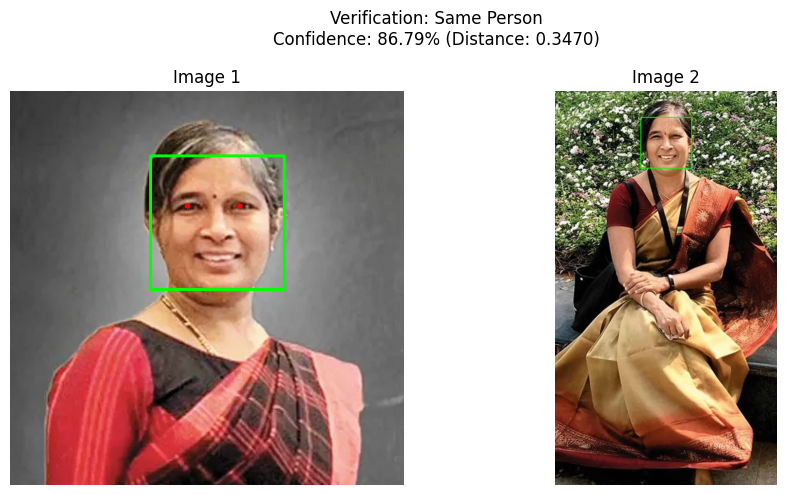

In [185]:

img1_path = "database/radha.png"
img2_path = "database/radha2.png"
result = verify_faces(img1_path, img2_path)
plot_faces_with_landmarks(img1_path, img2_path, result)

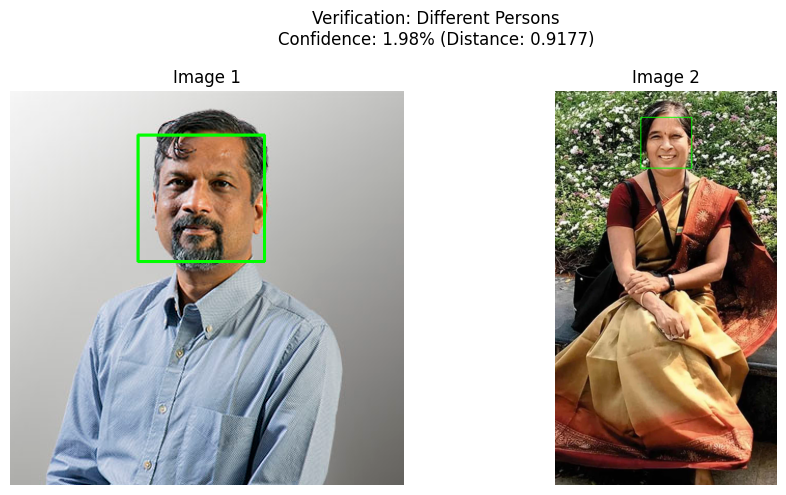

In [167]:
img1_path = "database/sridhar.png"
img2_path = "database/radha2.png"
result = verify_faces(img1_path, img2_path)
plot_faces_with_landmarks(img1_path, img2_path, result)

In [170]:
import cv2
import matplotlib.pyplot as plt
from deepface import DeepFace

def analyze_and_display_face_attributes(img_path):
    # Perform facial attribute analysis
    result = DeepFace.analyze(img_path=img_path, actions=['age', 'gender', 'emotion'])

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract facial area
    face_data = DeepFace.extract_faces(img_path=img_path)[0]["facial_area"]
    x, y, w, h = face_data["x"], face_data["y"], face_data["w"], face_data["h"]

    # Draw bounding box
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Prepare annotation text
    annotations = f"Age: {result[0]['age']}\nGender: {result[0]['dominant_gender']}\nEmotion: {result[0]['dominant_emotion']}"

    # Display image with annotations
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.text(x, y - 10, annotations, color="white", fontsize=10, bbox=dict(facecolor="black", alpha=0.5))
    plt.title("Facial Attribute Analysis")
    plt.show()

Action: emotion: 100%|██████████| 3/3 [00:00<00:00, 12.35it/s]


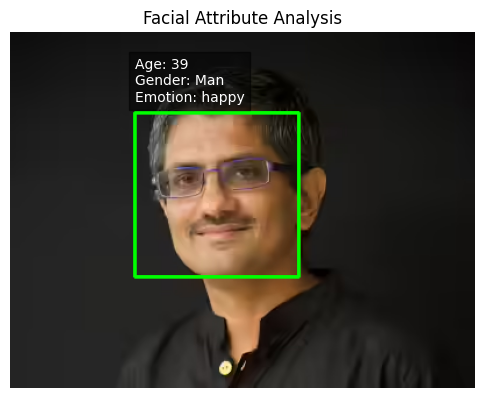

In [171]:
img_path = "database/shailesh.png"
analyze_and_display_face_attributes(img_path)

In [173]:
import cv2
import matplotlib.pyplot as plt
from deepface import DeepFace
import pandas as pd

def recognize_and_display_face(img_path, db_path, model_name="VGG-Face"):
    # Load the original image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Extract faces
    faces = DeepFace.extract_faces(img_path=img_path, enforce_detection=False)
    
    if len(faces) == 0:
        print("No faces found in the image.")
        return
    
    # Draw bounding boxes on the original image
    for i, face in enumerate(faces):
        x, y, w, h = face['facial_area']['x'], face['facial_area']['y'], face['facial_area']['w'], face['facial_area']['h']
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img_rgb, str(i+1), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display the original image with bounding boxes
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title("Query Image with Detected Faces")
    plt.axis("off")
    plt.show()
    
    # For each face, find top 3 matches
    for i, face in enumerate(faces):
        face_img = face['face']
        dfs = DeepFace.find(img_path=face_img, db_path=db_path, model_name=model_name, enforce_detection=False, silent=True)
        
        if len(dfs) > 0 and not dfs[0].empty:
            top_matches = dfs[0].head(3)
            num_matches = len(top_matches)
            
            # Create subplot for this face and its matches
            fig, axes = plt.subplots(1, 1 + num_matches, figsize=(5 * (1 + num_matches), 5))
            
            # Show the face
            axes[0].imshow(face_img)
            axes[0].set_title(f"Face {i+1}")
            axes[0].axis("off")
            
            # Show top matches
            for j, match in enumerate(top_matches.itertuples()):
                match_path = match.identity
                match_img = cv2.imread(match_path)
                if match_img is not None:
                    match_img = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)
                    axes[j+1].imshow(match_img)
                    axes[j+1].set_title(f"Match {j+1}: {match_path.split('/')[-1]}\Similarity: {match.confidence:.4f}")
                    axes[j+1].axis("off")
                else:
                    axes[j+1].text(0.5, 0.5, "Image not found", ha='center', va='center')
                    axes[j+1].set_title(f"Match {j+1}")
                    axes[j+1].axis("off")
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"No matches found for Face {i+1}.")

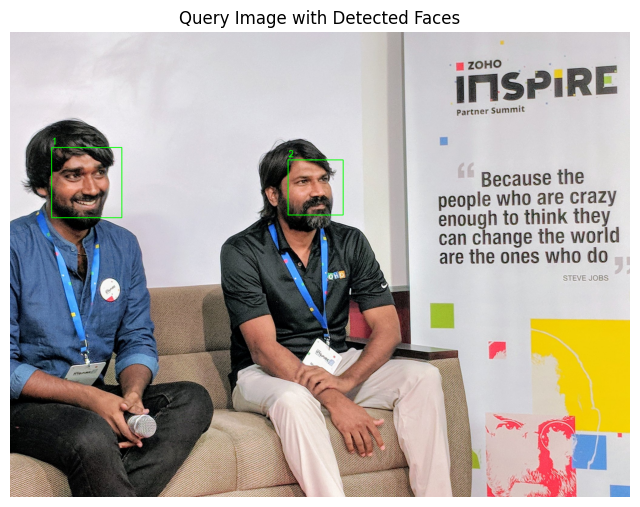

No matches found for Face 1.


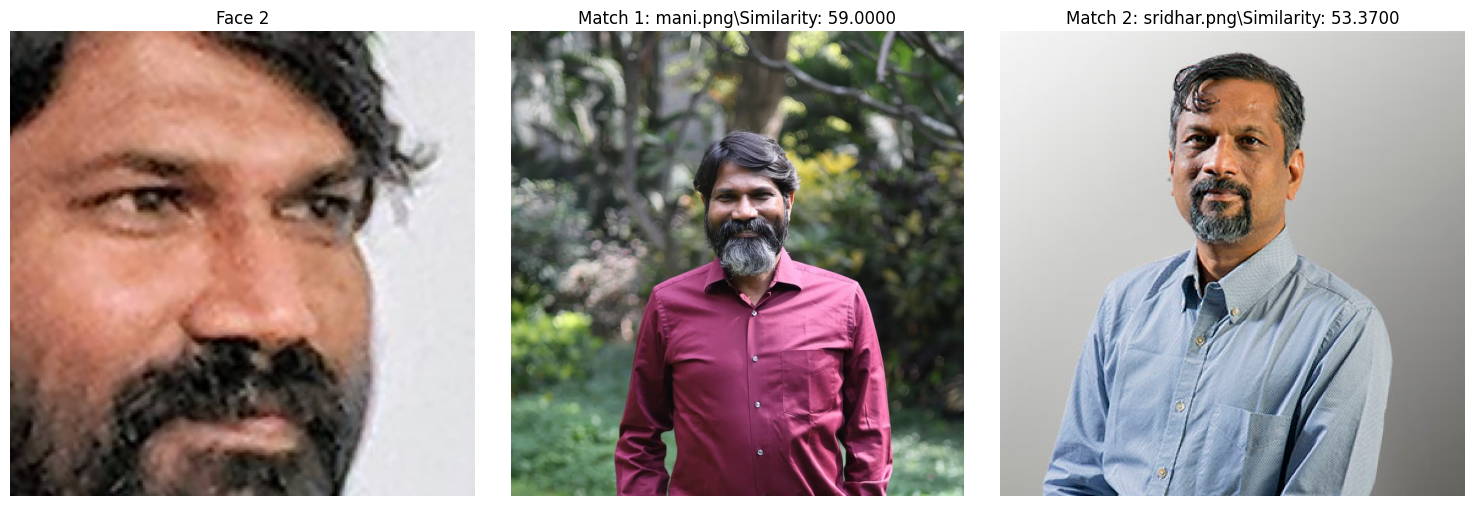

In [174]:
# Example usage
img_path = "query/mani2.png"
db_path = "database"
x=recognize_and_display_face(img_path, db_path)

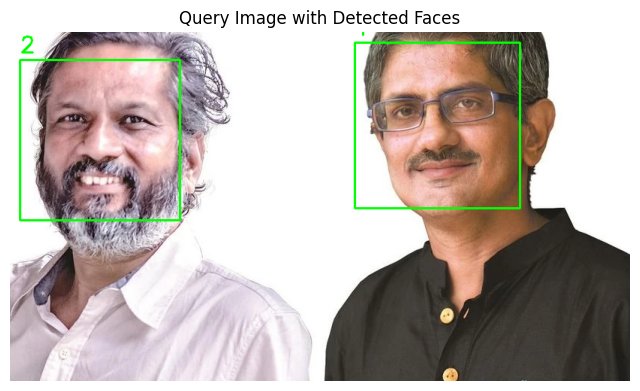

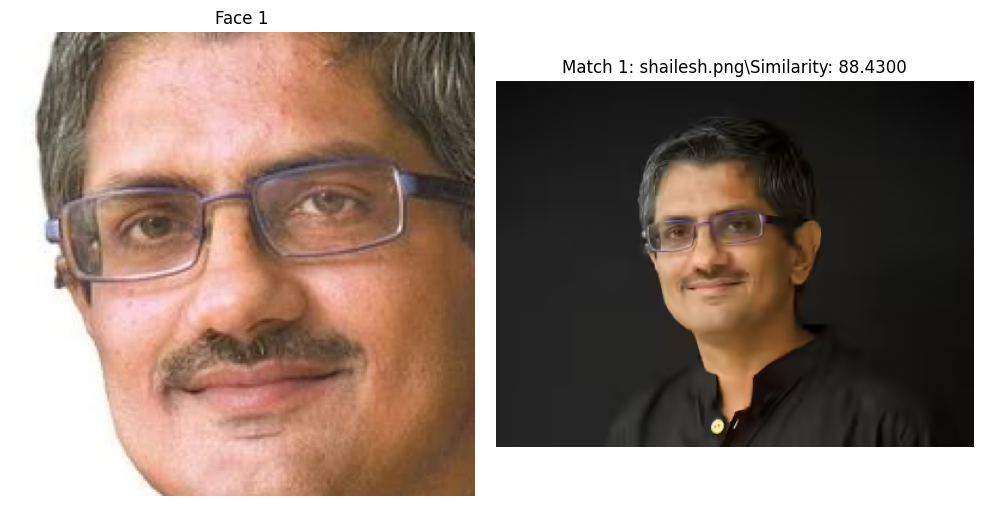

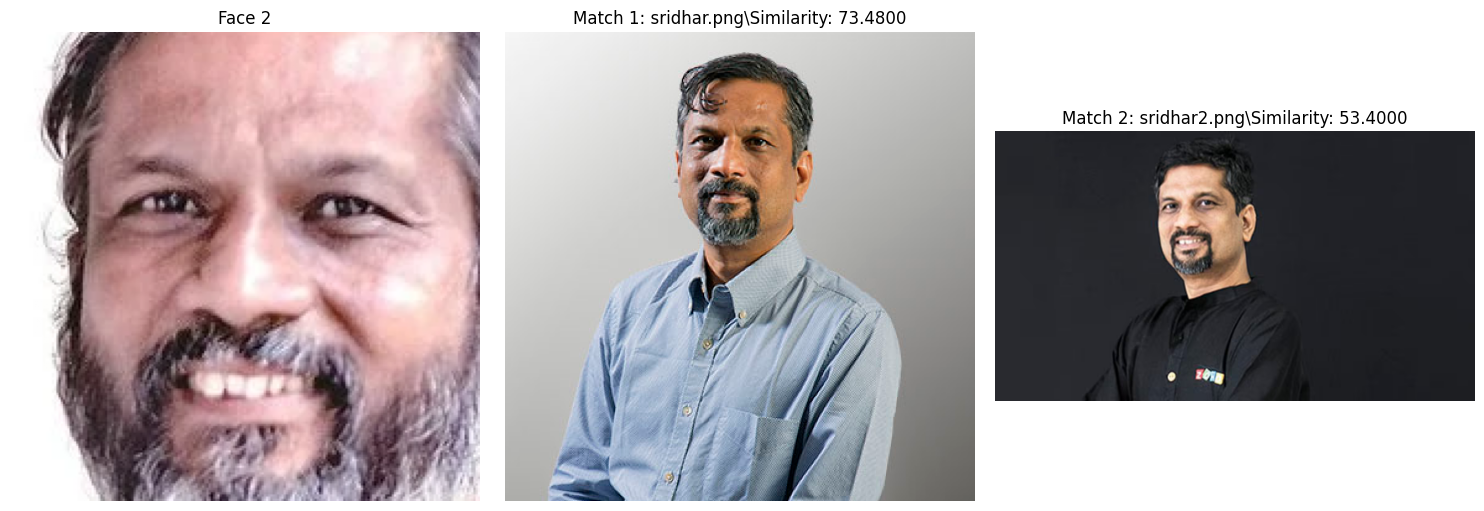

In [179]:
# Example usage
img_path = "query/image.png"
db_path = "database"
x=recognize_and_display_face(img_path, db_path)